<h1 style="background-color:DodgerBlue;"> Anamoly detection || Machine Learning ➤ Local Outlier Factor (LOF)</h1>

## 🧪 **Scenario: Monitor Sensor data **
- Goal: Detect early warning signs of potential machine failure, based on machinery sensor data .

- `vibration_level`
- `motor_temp`
- `pressure`
- `torque`
- `sound_db`

** Why Use Local Outlier Factor (LOF)**   
Since LOF is based on **local density**, it's great for spotting anomalies where a data point might look okay globally, but is strange relative to its local neighbors.



### 🐍 **1. Generate Sensor Data**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA

# Seed
np.random.seed(99)

# Normal cycles (600 samples)
normal_data = {
    'vibration_level': np.random.normal(5, 1, 600),
    'motor_temp': np.random.normal(70, 5, 600),
    'pressure': np.random.normal(30, 3, 600),
    'torque': np.random.normal(150, 10, 600),
    'sound_db': np.random.normal(60, 4, 600)
}

# Abnormal/faulty cycles (40 samples)
faulty_data = {
    'vibration_level': np.random.normal(15, 2, 40),
    'motor_temp': np.random.normal(95, 10, 40),
    'pressure': np.random.normal(10, 2, 40),
    'torque': np.random.normal(250, 15, 40),
    'sound_db': np.random.normal(85, 6, 40)
}

# Combine
df_normal = pd.DataFrame(normal_data)
df_faulty = pd.DataFrame(faulty_data)
df = pd.concat([df_normal, df_faulty], ignore_index=True).sample(frac=1).reset_index(drop=True)
df.head()

,vibration_level,motor_temp,pressure,torque,sound_db
0,5.414534,57.047451,33.821194,157.294601,61.458289
1,6.165405,66.729598,24.941698,149.380796,59.484013
2,3.183207,74.212978,32.745628,129.713896,54.800182
3,4.516894,72.717206,29.439349,153.549294,58.795691
4,4.503353,69.168201,33.718254,156.694674,60.260484


### 🔎 **2. Apply Local Outlier Factor (LOF)**

In [2]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

# Fit LOF model
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.06)
y_pred = clf.fit_predict(X_scaled)

# Add predictions to dataframe
df['anomaly'] = (y_pred == -1)
df.head()

,vibration_level,motor_temp,pressure,torque,sound_db,anomaly
0,5.414534,57.047451,33.821194,157.294601,61.458289,False
1,6.165405,66.729598,24.941698,149.380796,59.484013,False
2,3.183207,74.212978,32.745628,129.713896,54.800182,False
3,4.516894,72.717206,29.439349,153.549294,58.795691,False
4,4.503353,69.168201,33.718254,156.694674,60.260484,False


### 📈 **3. Visualize with PCA**

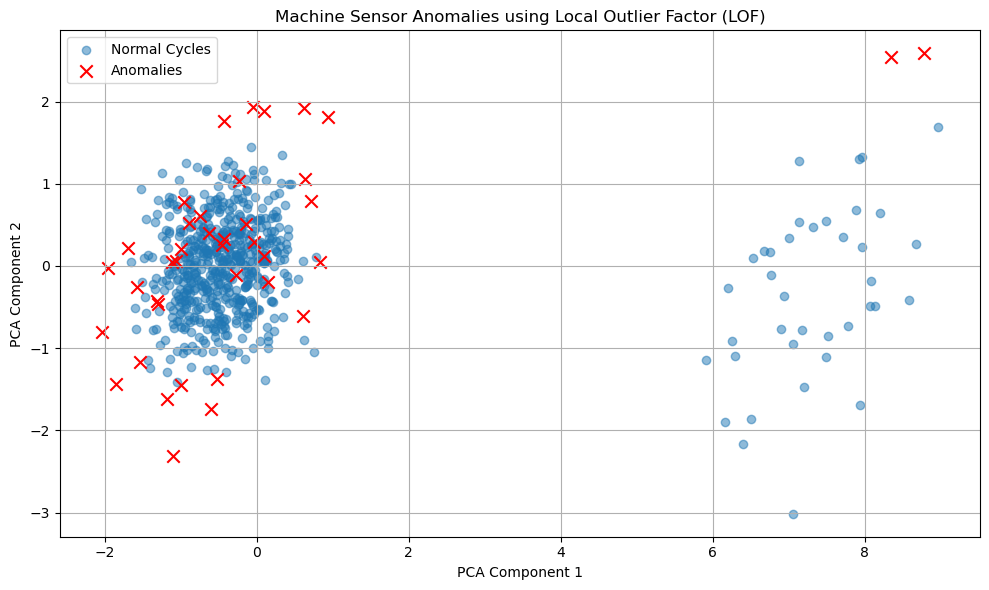

In [3]:
# Project to 2D for plotting
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
plt.scatter(df[df['anomaly'] == False]['pca_1'], 
            df[df['anomaly'] == False]['pca_2'], 
            label='Normal Cycles', alpha=0.5)

plt.scatter(df[df['anomaly'] == True]['pca_1'], 
            df[df['anomaly'] == True]['pca_2'], 
            color='red', label='Anomalies', marker='x', s=80)

plt.title('Machine Sensor Anomalies using Local Outlier Factor (LOF)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 🧠 **Interpretation**

- 🔴 **Red Xs** = Cycles where sensor patterns were significantly different from their neighbors.
- ✅ **Normal clusters** show consistent density; LOF spots anything with **lower local density**.
- ⚙️ **Why LOF?** Great when the **local context** matters—like detecting a weak motor among strong ones even if global stats look okay.








### 🧠 **What This Does**
- Combines the existing training data with the **new sample**  
- Recomputes LOF **densities including the new sample**  
- Checks if the new sample is flagged (`-1`) or not (`1`)

---

         

### 🧪 **5. Test a New Sample Using LOF**
> 🛑 Important: LOF is an *unsupervised, non-predictive model*, meaning it's **not directly usable for future predictions** (it doesn’t have a `.predict()` method after training).

However, we can **retrain LOF with all data + the new sample** and check if the **new point gets flagged**. 

> ⚠️ Since `LocalOutlierFactor` is *not predictive*, this approach retrains on each test — fine for occasional samples, but not scalable for real-time production.

If you're planning for **streaming or continuous anomaly detection**, we could:
- Use **Isolation Forest** instead (supports `.predict()` on new data)
- Or Use **online learning or deep learning-based methods** like Autoencoders

Here's how to do it:

In [4]:
# Example new sample: suspicious machine cycle
new_sample = pd.DataFrame([{
    'vibration_level': 14.5,
    'motor_temp': 98,
    'pressure': 12,
    'torque': 245,
    'sound_db': 87
}])

# Combine with existing data temporarily
df_temp = pd.concat([df.drop(columns=['anomaly', 'pca_1', 'pca_2']), new_sample], ignore_index=True)

# Scale the combined data
X_temp_scaled = scaler.fit_transform(df_temp)

# Re-run LOF on the combined set
clf_temp = LocalOutlierFactor(n_neighbors=20, contamination=0.06)
y_temp_pred = clf_temp.fit_predict(X_temp_scaled)

# Extract the last prediction (the new sample)
is_anomaly = y_temp_pred[-1] == -1

# Output the result
if is_anomaly:
    print("🚨 The new sample is an ANOMALY.")
else:
    print("✅ The new sample is NORMAL.")

✅ The new sample is NORMAL.


### 💾 **5. Export Detected Anomalies (LOF)**

In [5]:
# Filter only the detected anomalies
anomalies_df = df[df['anomaly'] == True]

# Export to CSV
anomalies_df.to_csv('sensor_anomalies_lof.csv', index=False)

✅This will generate a file called `**sensor_anomalies_lof.csv**` 
containing only the suspicious machine cycles based on the LOF analysis. 🛡️


